### A/A testing of mobile app. It's necessary to compare two cases checking FPR metric on CR to purchase. It's known that the system is broken. Let's verify thesis about broken split-system and seek the reasons.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
from tqdm.auto import tqdm
%matplotlib inline

#### Have a look on the data

In [20]:
df = pd.read_csv('hw_aa.csv', sep =';')
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [9]:
df.version.value_counts()

v2.8.0      82835
v2.9.0      23954
v3.8.0.0    11804
v3.7.4.0     8425
Name: version, dtype: int64

In [10]:
df.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [11]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

#### Create two subsets

In [12]:
df_0 = df[df['experimentVariant'] == 0]
df_1 = df[df['experimentVariant'] == 1]

#### Turn on A/A-test and ensure that FPR > alpha

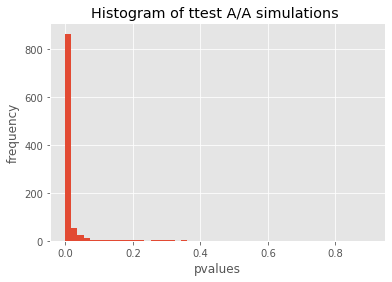

0.937

In [18]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# launch A/A-test simulations
for i in tqdm(range(simulations)):
    s1 = df_0.purchase.sample(n_s, replace = False).values
    s2 = df_1.purchase.sample(n_s, replace = False).values
    res.append(scipy.stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Check that the number of false-positive cases doesn't exceed the alpha level
sum(np.array(res) < 0.05) / simulations

#### Something has been wrong. Having this data to a first approximation we can divide the data by app version.

In [89]:
df_CR = df.groupby(['experimentVariant', 'version'], as_index = False).agg({'purchase': 'mean', 'uid': 'count'})

In [90]:
df_CR

,experimentVariant,version,purchase,uid
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


#### CR-rate in version 2.8.0 differs too much. We have the bug here probably. The rest of metrics are approximately equal. Let's calculate subsamples' p-value of app versoins. 

In [77]:
scipy.stats.ttest_ind(df.query('version == "v2.8.0" and experimentVariant == 0').purchase, df.query('version == "v2.8.0" and experimentVariant == 1').purchase)

Ttest_indResult(statistic=-42.963540840360324, pvalue=0.0)

In [78]:
scipy.stats.ttest_ind(df.query('version == "v2.9.0" and experimentVariant == 0').purchase, df.query('version == "v2.9.0" and experimentVariant == 1').purchase)

Ttest_indResult(statistic=0.9979597634962479, pvalue=0.31830895167207446)

In [79]:
scipy.stats.ttest_ind(df.query('version == "v3.7.4.0" and experimentVariant == 0').purchase, df.query('version == "v3.7.4.0" and experimentVariant == 1').purchase)

Ttest_indResult(statistic=-0.5874925850487471, pvalue=0.5568886771079735)

In [80]:
scipy.stats.ttest_ind(df.query('version == "v3.8.0.0" and experimentVariant == 0').purchase, df.query('version == "v3.8.0.0" and experimentVariant == 1').purchase)

Ttest_indResult(statistic=-1.1956188950206779, pvalue=0.23186933664059722)

#### P-value of 2.8.0 version < 0.05. It means that the version subsamples statistically differ that shouldn't be (we want to accept the null hypothesis). Thus we have to exclude the version from the data and launch A/A-test again.

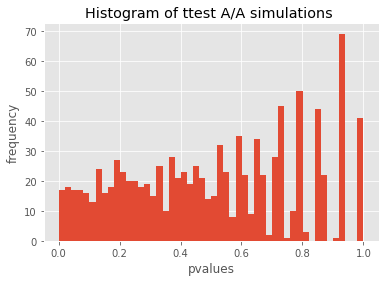

0.042

In [85]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# launch A/A-test simulations
for i in tqdm(range(simulations)):
    s1 = df_0.query('version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df_1.query('version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(scipy.stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Check that the number of false-positive cases doesn't exceed the alpha level
sum(np.array(res) < 0.05) / simulations

#### 0.042 < 0.05. Pvalue have to be almost equal to our alpha in this case.
#### Change pvalue to 0.01 and launch the test again to confirm validity of our assumption about version 2.8.0 

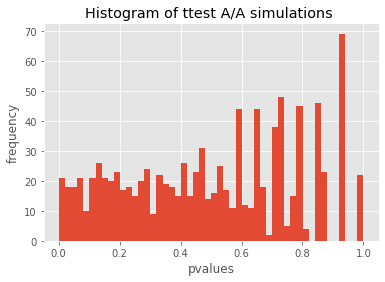

0.009

In [91]:
n = 100000
simulations = 1000
n_s = 1000
res = []

# launch A/A-test simulations
for i in tqdm(range(simulations)):
    s1 = df_0.query('version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    s2 = df_1.query('version != "v2.8.0"').purchase.sample(n_s, replace = False).values
    res.append(scipy.stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Check that the number of false-positive cases doesn't exceed the alpha level
sum(np.array(res) < 0.01) / simulations

#### 0.009  < 0.01

#### The output: it may be argued that the CR-bug in version 2.8.0 with the highest level of confidence. In other versions CR rate approximately equal.